In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import xgboost as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=4

In [3]:
print FOLD

4


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True,with_l3=True,with_l4=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                                                            ,
                    'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl'                   ,
                    'l3_3000_ridge_fold{}_False_d478.pkl', 'l3_3003_conv_fold{}_False_d478.pkl', 'l3_3006_xgb_fold{}_False_d478.pkl', 'l3_3001_lgb_fold{}_False_d478.pkl'                    
                    
                   ])

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,max_depth=4,subsample=1,C=0.1,
                                    learning_rate=0.02,min_child_weight=1,objective='reg:l1f0',
                                     gamma=0,reg_alpha=0,reg_lambda=1 ):
        models=[]
        scores=[]
        d_train = lgb.DMatrix(trainX, label=trainy)
        d_valid = lgb.DMatrix(validX, label=validy)
        
        if 1:
            params = {}
            params['eta'] = learning_rate
            params['objective'] = objective
            params['eval_metric'] = 'rmse'
            params['max_depth'] = max_depth
            params['colsample_bytree'] = colsample_bytree
            params['subsample'] = subsample
            params['min_child_weight'] = min_child_weight 
            params['gamma'] = gamma            
            params['reg_alpha'] = reg_alpha            
            params['reg_lambda'] = reg_lambda            
            params['silent'] = 1
            params['nthread'] = 8
            params['tree_method']='hist'
            print i, params
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            
            gbm = lgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=50)


            models.append(gbm)
            validpred=gbm.predict(d_valid,ntree_limit=gbm.best_ntree_limit)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(d_train,ntree_limit=gbm.best_ntree_limit)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    d_test = lgb.DMatrix(testX, label=testy)    
    test_pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        d_test = lgb.DMatrix(X)    
        pred=model.predict(d_test,ntree_limit=model.best_ntree_limit).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    d_test = lgb.DMatrix(X)    
    pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)

    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'learning_rate': 0.02,
 'max_depth': 8,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'subsample': 1}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
def ff(offset):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    #validpreds[offset]=[validpred,pred478]
    return offset, [validpred,pred478]
    #pickle.dump(validpreds, open('3005_rf_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [24]:
j=FOLD
validpreds={}

In [25]:
p = Pool(1,maxtasksperchild=1)



1
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1572
0
(201296, 1, 36) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 260) (201296,) (201296,)
(49444, 1, 36) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 260) (49444,) (49444,)
(5803, 1, 36) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 260) (5803,) (5803,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38606	valid-rmse:2.42535
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.981191	valid-rmse:0.995889
[100]	train-rmse:0.573203	valid-rmse:0.5847
[150]	train-rmse:0.48941	valid-rmse:0.505346
[200]	train-rmse:0.4733	valid-rmse:0.493627
[250]	train-rmse:0.46769	valid-rmse:0.492081
[300]	train-rmse:0.463939	valid-rmse:0.4919
Stopping. Best iteration:
[285]	train-rmse:0.464944	valid-rmse:0.491889

0.21617277 0.24195454
[0.24195454]
-1 mean score 0.24195454
0.195210292935


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.918146  0.010964  0.204310    7  2017-04-16
472     2.507290  2.523065 -0.015774  0.205503    1  2017-04-17
473     2.661330  2.661991 -0.000661  0.232655    2  2017-04-18
474     2.754815  2.742694  0.012120  0.195370    3  2017-04-19
475     2.713762  2.708848  0.004914  0.214016    4  2017-04-20
476     2.999000  2.979615  0.019385  0.144155    5  2017-04-21
477     3.075529  3.077947 -0.002418  0.170464    6  2017-04-22

0.195210292935


pred         y     error    error2  day        date
dayidx                                                         
471     2.918146  2.929110  0.010964  0.204310    7  2017-04-16
472     2.523065  2.507290 -0.015774  0.205503    1  2017-04-17
473     2.661991  2.661330 -0.000661  0.232655    2  2017-04-18
474     2.742694  2.754815  0.012120  0.195370    3  2017-04-19
475     2.708848  2.713762  0.004914  0.214016    4  2017-04-20
476     2.979615  2.999000  0.019385  0.144155    5  2017-04-21
477     3.077947  3.075529 -0.002418  0.170464    6  2017-04-22

(829, 260)


In [26]:
results=p.map(ff, range(1,40),chunksize=1)



2
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201067, 2) (49390, 2)
train/valid # (201067, 2) (49390, 2)
rand split across time
train has 201067 records out of 389630 records
valid has 49390 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1570
0
(201067, 1, 36) (201067, 7, 32) (201067, 1) (201067, 1)
(201067, 260) (201067,) (201067,)
(49390, 1, 36) (49390, 7, 32) (49390, 1) (49390, 1)
(49390, 260) (49390,) (49390,)
(6632, 1, 36) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 260) (6632,) (6632,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38585	valid-rmse:2.42511
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.983744	valid-rmse:0.996194
[100]	train-rmse:0.578278	valid-rmse:0.587814
[150]	train-rmse:0.49574	valid-rmse:0.510445
[200]	train-rmse:0.479776	valid-rmse:0.499692
[250]	train-rmse:0.474296	valid-rmse:0.498508
[300]	train-rmse:0.470221	valid-rmse:0.498507
Stopping. Best iteration:
[275]	train-rmse:0.472141	valid-rmse:0.498481

0.22291756 0.2484835
[0.2484835]
-1 mean score 0.2484835
0.201492995024


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913453  0.015657  0.220230    7  2017-04-16
472     2.507290  2.521686 -0.014395  0.210871    1  2017-04-17
473     2.661330  2.652196  0.009133  0.235256    2  2017-04-18
474     2.754815  2.738878  0.015937  0.203146    3  2017-04-19
475     2.713762  2.714749 -0.000988  0.224176    4  2017-04-20
476     2.999000  2.986426  0.012574  0.147070    5  2017-04-21
477     3.075529  3.067068  0.008461  0.169702    6  2017-04-22

0.201492995024


pred         y     error    error2  day        date
dayidx                                                         
471     2.913453  2.929110  0.015657  0.220230    7  2017-04-16
472     2.521686  2.507290 -0.014395  0.210871    1  2017-04-17
473     2.652196  2.661330  0.009133  0.235256    2  2017-04-18
474     2.738878  2.754815  0.015937  0.203146    3  2017-04-19
475     2.714749  2.713762 -0.000988  0.224176    4  2017-04-20
476     2.986426  2.999000  0.012574  0.147070    5  2017-04-21
477     3.067068  3.075529  0.008461  0.169702    6  2017-04-22

(829, 260)


3
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (200884, 2) (49346, 2)
train/valid # (200884, 2) (49346, 2)
rand split across time
train has 200884 records out of 389630 records
valid has 49346 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1569
0
(200884, 1, 36) (200884, 7, 32) (200884, 1) (200884, 1)
(200884, 260) (200884,) (200884,)
(49346, 1, 36) (49346, 7, 32) (49346, 1) (49346, 1)
(49346, 260) (49346,) (49346,)
(7461, 1, 36) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 260) (7461,) (7461,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38566	valid-rmse:2.42486
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.984494	valid-rmse:0.999235
[100]	train-rmse:0.579967	valid-rmse:0.591902
[150]	train-rmse:0.497375	valid-rmse:0.514217
[200]	train-rmse:0.481474	valid-rmse:0.50313
[250]	train-rmse:0.476138	valid-rmse:0.501688
[300]	train-rmse:0.472306	valid-rmse:0.501629
Stopping. Best iteration:
[271]	train-rmse:0.47437	valid-rmse:0.501576

0.22502673 0.2515783
[0.2515783]
-1 mean score 0.2515783
0.205415338278


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894873  0.034237  0.218889    7  2017-04-16
472     2.507290  2.516002 -0.008712  0.212226    1  2017-04-17
473     2.661330  2.640382  0.020948  0.245904    2  2017-04-18
474     2.754815  2.750181  0.004634  0.210145    3  2017-04-19
475     2.713762  2.709025  0.004737  0.227421    4  2017-04-20
476     2.999000  2.985490  0.013509  0.148548    5  2017-04-21
477     3.075529  3.065489  0.010041  0.174774    6  2017-04-22

0.205415338278


pred         y     error    error2  day        date
dayidx                                                         
471     2.894873  2.929110  0.034237  0.218889    7  2017-04-16
472     2.516002  2.507290 -0.008712  0.212226    1  2017-04-17
473     2.640382  2.661330  0.020948  0.245904    2  2017-04-18
474     2.750181  2.754815  0.004634  0.210145    3  2017-04-19
475     2.709025  2.713762  0.004737  0.227421    4  2017-04-20
476     2.985490  2.999000  0.013509  0.148548    5  2017-04-21
477     3.065489  3.075529  0.010041  0.174774    6  2017-04-22

(829, 260)


4
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (200719, 2) (49309, 2)
train/valid # (200719, 2) (49309, 2)
rand split across time
train has 200719 records out of 389630 records
valid has 49309 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1568
0
(200719, 1, 36) (200719, 7, 32) (200719, 1) (200719, 1)
(200719, 260) (200719,) (200719,)
(49309, 1, 36) (49309, 7, 32) (49309, 1) (49309, 1)
(49309, 260) (49309,) (49309,)
(8290, 1, 36) (8290, 7, 32) (8290, 1) (8290, 1)
(8290, 260) (8290,) (8290,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38565	valid-rmse:2.42479
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.985223	valid-rmse:0.996958
[100]	train-rmse:0.581281	valid-rmse:0.590487
[150]	train-rmse:0.499098	valid-rmse:0.514032
[200]	train-rmse:0.48289	valid-rmse:0.503536
[250]	train-rmse:0.477419	valid-rmse:0.502335
[300]	train-rmse:0.473788	valid-rmse:0.502338
Stopping. Best iteration:
[266]	train-rmse:0.476094	valid-rmse:0.502282

0.22666551 0.2522875
[0.2522875]
-1 mean score 0.2522875
0.204277545214


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899012  0.030098  0.221288    7  2017-04-16
472     2.507290  2.509262 -0.001971  0.211738    1  2017-04-17
473     2.661330  2.631895  0.029435  0.240094    2  2017-04-18
474     2.754815  2.737359  0.017456  0.206269    3  2017-04-19
475     2.713762  2.710447  0.003315  0.226057    4  2017-04-20
476     2.999000  2.976262  0.022738  0.153258    5  2017-04-21
477     3.075529  3.066257  0.009272  0.171238    6  2017-04-22

0.204277545214


pred         y     error    error2  day        date
dayidx                                                         
471     2.899012  2.929110  0.030098  0.221288    7  2017-04-16
472     2.509262  2.507290 -0.001971  0.211738    1  2017-04-17
473     2.631895  2.661330  0.029435  0.240094    2  2017-04-18
474     2.737359  2.754815  0.017456  0.206269    3  2017-04-19
475     2.710447  2.713762  0.003315  0.226057    4  2017-04-20
476     2.976262  2.999000  0.022738  0.153258    5  2017-04-21
477     3.066257  3.075529  0.009272  0.171238    6  2017-04-22

(829, 260)


5
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (200518, 2) (49258, 2)
train/valid # (200518, 2) (49258, 2)
rand split across time
train has 200518 records out of 389630 records
valid has 49258 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1566
0
(200518, 1, 36) (200518, 7, 32) (200518, 1) (200518, 1)
(200518, 260) (200518,) (200518,)
(49258, 1, 36) (49258, 7, 32) (49258, 1) (49258, 1)
(49258, 260) (49258,) (49258,)
(9119, 1, 36) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 260) (9119,) (9119,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38591	valid-rmse:2.42498
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.986055	valid-rmse:0.99958
[100]	train-rmse:0.58247	valid-rmse:0.593436
[150]	train-rmse:0.500475	valid-rmse:0.516404
[200]	train-rmse:0.484649	valid-rmse:0.505562
[250]	train-rmse:0.479388	valid-rmse:0.504247
[300]	train-rmse:0.475744	valid-rmse:0.504202
Stopping. Best iteration:
[266]	train-rmse:0.478143	valid-rmse:0.50416

0.2286206 0.25417686
[0.25417686]
-1 mean score 0.25417686
0.2057492733


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893139  0.035971  0.219016    7  2017-04-16
472     2.507290  2.516134 -0.008844  0.216894    1  2017-04-17
473     2.661330  2.622097  0.039233  0.240461    2  2017-04-18
474     2.754815  2.730758  0.024057  0.205614    3  2017-04-19
475     2.713762  2.705822  0.007940  0.229248    4  2017-04-20
476     2.999000  2.975036  0.023963  0.155714    5  2017-04-21
477     3.075529  3.063352  0.012177  0.173297    6  2017-04-22

0.2057492733


pred         y     error    error2  day        date
dayidx                                                         
471     2.893139  2.929110  0.035971  0.219016    7  2017-04-16
472     2.516134  2.507290 -0.008844  0.216894    1  2017-04-17
473     2.622097  2.661330  0.039233  0.240461    2  2017-04-18
474     2.730758  2.754815  0.024057  0.205614    3  2017-04-19
475     2.705822  2.713762  0.007940  0.229248    4  2017-04-20
476     2.975036  2.999000  0.023963  0.155714    5  2017-04-21
477     3.063352  3.075529  0.012177  0.173297    6  2017-04-22

(829, 260)


6
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 15.133374
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (200306, 2) (49207, 2)
train/valid # (200306, 2) (49207, 2)
rand split across time
train has 200306 records out of 389630 records
valid has 49207 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1564
0
(200306, 1, 36) (200306, 7, 32) (200306, 1) (200306, 1)
(200306, 260) (200306,) (200306,)
(49207, 1, 36) (49207, 7, 32) (49207, 1) (49207, 1)
(49207, 260) (49207,) (49207,)
(9948, 1, 36) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 260) (9948,) (9948,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38603	valid-rmse:2.42528
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.9866	valid-rmse:1.00092
[100]	train-rmse:0.583646	valid-rmse:0.594685
[150]	train-rmse:0.501703	valid-rmse:0.517498
[200]	train-rmse:0.486102	valid-rmse:0.506473
[250]	train-rmse:0.480846	valid-rmse:0.505123
[300]	train-rmse:0.477347	valid-rmse:0.505114
Stopping. Best iteration:
[270]	train-rmse:0.479212	valid-rmse:0.505038

0.2296438 0.25506338
[0.25506338]
-1 mean score 0.25506338
0.20841909945


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907543  0.021567  0.222959    7  2017-04-16
472     2.507290  2.525294 -0.018004  0.220172    1  2017-04-17
473     2.661330  2.628435  0.032895  0.248751    2  2017-04-18
474     2.754815  2.731662  0.023153  0.206690    3  2017-04-19
475     2.713762  2.711462  0.002299  0.232995    4  2017-04-20
476     2.999000  2.966402  0.032598  0.155040    5  2017-04-21
477     3.075529  3.073529  0.002001  0.172325    6  2017-04-22

0.20841909945


pred         y     error    error2  day        date
dayidx                                                         
471     2.907543  2.929110  0.021567  0.222959    7  2017-04-16
472     2.525294  2.507290 -0.018004  0.220172    1  2017-04-17
473     2.628435  2.661330  0.032895  0.248751    2  2017-04-18
474     2.731662  2.754815  0.023153  0.206690    3  2017-04-19
475     2.711462  2.713762  0.002299  0.232995    4  2017-04-20
476     2.966402  2.999000  0.032598  0.155040    5  2017-04-21
477     3.073529  3.075529  0.002001  0.172325    6  2017-04-22

(829, 260)


7
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 16.310143
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (200088, 2) (49151, 2)
train/valid # (200088, 2) (49151, 2)
rand split across time
train has 200088 records out of 389630 records
valid has 49151 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1563
0
(200088, 1, 36) (200088, 7, 32) (200088, 1) (200088, 1)
(200088, 260) (200088,) (200088,)
(49151, 1, 36) (49151, 7, 32) (49151, 1) (49151, 1)
(49151, 260) (49151,) (49151,)
(10777, 1, 36) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 260) (10777,) (10777,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38617	valid-rmse:2.42536
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.987459	valid-rmse:0.999364
[100]	train-rmse:0.585129	valid-rmse:0.59429
[150]	train-rmse:0.50346	valid-rmse:0.518311
[200]	train-rmse:0.487964	valid-rmse:0.507895
[250]	train-rmse:0.482686	valid-rmse:0.506827
[300]	train-rmse:0.478632	valid-rmse:0.506896
Stopping. Best iteration:
[262]	train-rmse:0.481572	valid-rmse:0.5068

0.23191139 0.25684634
[0.25684634]
-1 mean score 0.25684634
0.211258620024


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903549  0.025560  0.227261    7  2017-04-16
472     2.507290  2.533972 -0.026681  0.225110    1  2017-04-17
473     2.661330  2.633691  0.027639  0.253571    2  2017-04-18
474     2.754815  2.725893  0.028922  0.208762    3  2017-04-19
475     2.713762  2.704650  0.009111  0.232941    4  2017-04-20
476     2.999000  2.971445  0.027555  0.153438    5  2017-04-21
477     3.075529  3.084195 -0.008666  0.177726    6  2017-04-22

0.211258620024


pred         y     error    error2  day        date
dayidx                                                         
471     2.903549  2.929110  0.025560  0.227261    7  2017-04-16
472     2.533972  2.507290 -0.026681  0.225110    1  2017-04-17
473     2.633691  2.661330  0.027639  0.253571    2  2017-04-18
474     2.725893  2.754815  0.028922  0.208762    3  2017-04-19
475     2.704650  2.713762  0.009111  0.232941    4  2017-04-20
476     2.971445  2.999000  0.027555  0.153438    5  2017-04-21
477     3.084195  3.075529 -0.008666  0.177726    6  2017-04-22

(829, 260)


8
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 17.574337
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199858, 2) (49091, 2)
train/valid # (199858, 2) (49091, 2)
rand split across time
train has 199858 records out of 389630 records
valid has 49091 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1561
0
(199858, 1, 36) (199858, 7, 32) (199858, 1) (199858, 1)
(199858, 260) (199858,) (199858,)
(49091, 1, 36) (49091, 7, 32) (49091, 1) (49091, 1)
(49091, 260) (49091,) (49091,)
(11606, 1, 36) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 260) (11606,) (11606,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38606	valid-rmse:2.4252
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.988909	valid-rmse:1.00292
[100]	train-rmse:0.587724	valid-rmse:0.599423
[150]	train-rmse:0.506382	valid-rmse:0.523426
[200]	train-rmse:0.490696	valid-rmse:0.512737
[250]	train-rmse:0.485464	valid-rmse:0.511411
[300]	train-rmse:0.481658	valid-rmse:0.511421
Stopping. Best iteration:
[261]	train-rmse:0.484694	valid-rmse:0.511362

0.2349284 0.26149106
[0.26149106]
-1 mean score 0.26149106
0.213816151023


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914814  0.014296  0.237386    7  2017-04-16
472     2.507290  2.529901 -0.022610  0.222143    1  2017-04-17
473     2.661330  2.639643  0.021687  0.255723    2  2017-04-18
474     2.754815  2.730022  0.024792  0.214846    3  2017-04-19
475     2.713762  2.706490  0.007272  0.231793    4  2017-04-20
476     2.999000  2.962189  0.036810  0.157736    5  2017-04-21
477     3.075529  3.083382 -0.007853  0.177086    6  2017-04-22

0.213816151023


pred         y     error    error2  day        date
dayidx                                                         
471     2.914814  2.929110  0.014296  0.237386    7  2017-04-16
472     2.529901  2.507290 -0.022610  0.222143    1  2017-04-17
473     2.639643  2.661330  0.021687  0.255723    2  2017-04-18
474     2.730022  2.754815  0.024792  0.214846    3  2017-04-19
475     2.706490  2.713762  0.007272  0.231793    4  2017-04-20
476     2.962189  2.999000  0.036810  0.157736    5  2017-04-21
477     3.083382  3.075529 -0.007853  0.177086    6  2017-04-22

(829, 260)


9
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 18.806503
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199635, 2) (49032, 2)
train/valid # (199635, 2) (49032, 2)
rand split across time
train has 199635 records out of 389630 records
valid has 49032 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1559
0
(199635, 1, 36) (199635, 7, 32) (199635, 1) (199635, 1)
(199635, 260) (199635,) (199635,)
(49032, 1, 36) (49032, 7, 32) (49032, 1) (49032, 1)
(49032, 260) (49032,) (49032,)
(12435, 1, 36) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 260) (12435,) (12435,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38579	valid-rmse:2.42488
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.989903	valid-rmse:1.00236
[100]	train-rmse:0.589705	valid-rmse:0.599976
[150]	train-rmse:0.508706	valid-rmse:0.52479
[200]	train-rmse:0.492807	valid-rmse:0.514415
[250]	train-rmse:0.487544	valid-rmse:0.513378
[300]	train-rmse:0.483396	valid-rmse:0.513433
Stopping. Best iteration:
[266]	train-rmse:0.486238	valid-rmse:0.513306

0.23642756 0.2634829
[0.2634829]
-1 mean score 0.2634829
0.214407473803


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911527  0.017583  0.237014    7  2017-04-16
472     2.507290  2.539656 -0.032365  0.221895    1  2017-04-17
473     2.661330  2.656196  0.005134  0.255974    2  2017-04-18
474     2.754815  2.726911  0.027904  0.218798    3  2017-04-19
475     2.713762  2.710941  0.002820  0.231072    4  2017-04-20
476     2.999000  2.963856  0.035144  0.160080    5  2017-04-21
477     3.075529  3.073256  0.002273  0.176020    6  2017-04-22

0.214407473803


pred         y     error    error2  day        date
dayidx                                                         
471     2.911527  2.929110  0.017583  0.237014    7  2017-04-16
472     2.539656  2.507290 -0.032365  0.221895    1  2017-04-17
473     2.656196  2.661330  0.005134  0.255974    2  2017-04-18
474     2.726911  2.754815  0.027904  0.218798    3  2017-04-19
475     2.710941  2.713762  0.002820  0.231072    4  2017-04-20
476     2.963856  2.999000  0.035144  0.160080    5  2017-04-21
477     3.073256  3.075529  0.002273  0.176020    6  2017-04-22

(829, 260)


10
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 19.926521
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199462, 2) (48989, 2)
train/valid # (199462, 2) (48989, 2)
rand split across time
train has 199462 records out of 389630 records
valid has 48989 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1558
0
(199462, 1, 36) (199462, 7, 32) (199462, 1) (199462, 1)
(199462, 260) (199462,) (199462,)
(48989, 1, 36) (48989, 7, 32) (48989, 1) (48989, 1)
(48989, 260) (48989,) (48989,)
(13264, 1, 36) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 260) (13264,) (13264,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38576	valid-rmse:2.42493
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.990278	valid-rmse:1.00584
[100]	train-rmse:0.590464	valid-rmse:0.603437
[150]	train-rmse:0.509521	valid-rmse:0.526959
[200]	train-rmse:0.493901	valid-rmse:0.515948
[250]	train-rmse:0.488683	valid-rmse:0.514462
[300]	train-rmse:0.484611	valid-rmse:0.514294
[350]	train-rmse:0.481104	valid-rmse:0.514389
Stopping. Best iteration:
[304]	train-rmse:0.484293	valid-rmse:0.514274

0.23453932 0.2644775
[0.2644775]
-1 mean score 0.2644775
0.212293550372


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914686  0.014424  0.232901    7  2017-04-16
472     2.507290  2.531604 -0.024314  0.219106    1  2017-04-17
473     2.661330  2.665137 -0.003807  0.256865    2  2017-04-18
474     2.754815  2.745050  0.009765  0.216668    3  2017-04-19
475     2.713762  2.721374 -0.007612  0.227979    4  2017-04-20
476     2.999000  2.974630  0.024369  0.158204    5  2017-04-21
477     3.075529  3.083777 -0.008248  0.174331    6  2017-04-22

0.212293550372


pred         y     error    error2  day        date
dayidx                                                         
471     2.914686  2.929110  0.014424  0.232901    7  2017-04-16
472     2.531604  2.507290 -0.024314  0.219106    1  2017-04-17
473     2.665137  2.661330 -0.003807  0.256865    2  2017-04-18
474     2.745050  2.754815  0.009765  0.216668    3  2017-04-19
475     2.721374  2.713762 -0.007612  0.227979    4  2017-04-20
476     2.974630  2.999000  0.024369  0.158204    5  2017-04-21
477     3.083777  3.075529 -0.008248  0.174331    6  2017-04-22

(829, 260)


11
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 21.05768
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199280, 2) (48945, 2)
train/valid # (199280, 2) (48945, 2)
rand split across time
train has 199280 records out of 389630 records
valid has 48945 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1556
0
(199280, 1, 36) (199280, 7, 32) (199280, 1) (199280, 1)
(199280, 260) (199280,) (199280,)
(48945, 1, 36) (48945, 7, 32) (48945, 1) (48945, 1)
(48945, 260) (48945,) (48945,)
(14093, 1, 36) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 260) (14093,) (14093,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38603	valid-rmse:2.4252
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.990707	valid-rmse:1.00376
[100]	train-rmse:0.591097	valid-rmse:0.602447
[150]	train-rmse:0.510112	valid-rmse:0.527352
[200]	train-rmse:0.494504	valid-rmse:0.516969
[250]	train-rmse:0.489243	valid-rmse:0.515794
[300]	train-rmse:0.48513	valid-rmse:0.515791
Stopping. Best iteration:
[279]	train-rmse:0.486735	valid-rmse:0.515758

0.23691048 0.26600638
[0.26600638]
-1 mean score 0.26600638
0.214459076524


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901546  0.027564  0.232897    7  2017-04-16
472     2.507290  2.529952 -0.022661  0.219902    1  2017-04-17
473     2.661330  2.658282  0.003048  0.262403    2  2017-04-18
474     2.754815  2.731013  0.023801  0.217357    3  2017-04-19
475     2.713762  2.725115 -0.011354  0.229794    4  2017-04-20
476     2.999000  2.974955  0.024045  0.162505    5  2017-04-21
477     3.075529  3.069091  0.006438  0.176356    6  2017-04-22

0.214459076524


pred         y     error    error2  day        date
dayidx                                                         
471     2.901546  2.929110  0.027564  0.232897    7  2017-04-16
472     2.529952  2.507290 -0.022661  0.219902    1  2017-04-17
473     2.658282  2.661330  0.003048  0.262403    2  2017-04-18
474     2.731013  2.754815  0.023801  0.217357    3  2017-04-19
475     2.725115  2.713762 -0.011354  0.229794    4  2017-04-20
476     2.974955  2.999000  0.024045  0.162505    5  2017-04-21
477     3.069091  3.075529  0.006438  0.176356    6  2017-04-22

(829, 260)


12
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 22.115147
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199068, 2) (48890, 2)
train/valid # (199068, 2) (48890, 2)
rand split across time
train has 199068 records out of 389630 records
valid has 48890 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1555
0
(199068, 1, 36) (199068, 7, 32) (199068, 1) (199068, 1)
(199068, 260) (199068,) (199068,)
(48890, 1, 36) (48890, 7, 32) (48890, 1) (48890, 1)
(48890, 260) (48890,) (48890,)
(14922, 1, 36) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 260) (14922,) (14922,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38626	valid-rmse:2.42535
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.991391	valid-rmse:1.00325
[100]	train-rmse:0.592211	valid-rmse:0.602163
[150]	train-rmse:0.511589	valid-rmse:0.527838
[200]	train-rmse:0.49583	valid-rmse:0.517793
[250]	train-rmse:0.490439	valid-rmse:0.516724
[300]	train-rmse:0.486059	valid-rmse:0.51688
Stopping. Best iteration:
[256]	train-rmse:0.489966	valid-rmse:0.516687

0.24006653 0.2669651
[0.2669651]
-1 mean score 0.2669651
0.215916395187


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895210  0.033900  0.238724    7  2017-04-16
472     2.507290  2.531262 -0.023972  0.218779    1  2017-04-17
473     2.661330  2.653100  0.008230  0.262107    2  2017-04-18
474     2.754815  2.722067  0.032748  0.220776    3  2017-04-19
475     2.713762  2.714725 -0.000964  0.229417    4  2017-04-20
476     2.999000  2.966425  0.032574  0.164959    5  2017-04-21
477     3.075529  3.065732  0.009797  0.176653    6  2017-04-22

0.215916395187


pred         y     error    error2  day        date
dayidx                                                         
471     2.895210  2.929110  0.033900  0.238724    7  2017-04-16
472     2.531262  2.507290 -0.023972  0.218779    1  2017-04-17
473     2.653100  2.661330  0.008230  0.262107    2  2017-04-18
474     2.722067  2.754815  0.032748  0.220776    3  2017-04-19
475     2.714725  2.713762 -0.000964  0.229417    4  2017-04-20
476     2.966425  2.999000  0.032574  0.164959    5  2017-04-21
477     3.065732  3.075529  0.009797  0.176653    6  2017-04-22

(829, 260)


13
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 23.15517
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (198858, 2) (48837, 2)
train/valid # (198858, 2) (48837, 2)
rand split across time
train has 198858 records out of 389630 records
valid has 48837 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1553
0
(198858, 1, 36) (198858, 7, 32) (198858, 1) (198858, 1)
(198858, 260) (198858,) (198858,)
(48837, 1, 36) (48837, 7, 32) (48837, 1) (48837, 1)
(48837, 260) (48837,) (48837,)
(15751, 1, 36) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 260) (15751,) (15751,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38637	valid-rmse:2.42561
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99178	valid-rmse:1.00812
[100]	train-rmse:0.593002	valid-rmse:0.606488
[150]	train-rmse:0.512381	valid-rmse:0.529819
[200]	train-rmse:0.496774	valid-rmse:0.518558
[250]	train-rmse:0.491361	valid-rmse:0.51708
[300]	train-rmse:0.486951	valid-rmse:0.516937
Stopping. Best iteration:
[291]	train-rmse:0.487611	valid-rmse:0.516904

0.23776418 0.2671896
[0.2671896]
-1 mean score 0.2671896
0.214737206697


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906262  0.022847  0.233063    7  2017-04-16
472     2.507290  2.529223 -0.021932  0.220853    1  2017-04-17
473     2.661330  2.666231 -0.004901  0.261532    2  2017-04-18
474     2.754815  2.735088  0.019727  0.218937    3  2017-04-19
475     2.713762  2.725247 -0.011485  0.232168    4  2017-04-20
476     2.999000  2.980486  0.018514  0.161154    5  2017-04-21
477     3.075529  3.063378  0.012151  0.175452    6  2017-04-22

0.214737206697


pred         y     error    error2  day        date
dayidx                                                         
471     2.906262  2.929110  0.022847  0.233063    7  2017-04-16
472     2.529223  2.507290 -0.021932  0.220853    1  2017-04-17
473     2.666231  2.661330 -0.004901  0.261532    2  2017-04-18
474     2.735088  2.754815  0.019727  0.218937    3  2017-04-19
475     2.725247  2.713762 -0.011485  0.232168    4  2017-04-20
476     2.980486  2.999000  0.018514  0.161154    5  2017-04-21
477     3.063378  3.075529  0.012151  0.175452    6  2017-04-22

(829, 260)


14
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 24.22639
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (198636, 2) (48781, 2)
train/valid # (198636, 2) (48781, 2)
rand split across time
train has 198636 records out of 389630 records
valid has 48781 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1551
0
(198636, 1, 36) (198636, 7, 32) (198636, 1) (198636, 1)
(198636, 260) (198636,) (198636,)
(48781, 1, 36) (48781, 7, 32) (48781, 1) (48781, 1)
(48781, 260) (48781,) (48781,)
(16580, 1, 36) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 260) (16580,) (16580,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38644	valid-rmse:2.42568
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.992196	valid-rmse:1.00415
[100]	train-rmse:0.593742	valid-rmse:0.603661
[150]	train-rmse:0.513249	valid-rmse:0.52962
[200]	train-rmse:0.497592	valid-rmse:0.519606
[250]	train-rmse:0.491925	valid-rmse:0.518561
[300]	train-rmse:0.4876	valid-rmse:0.518773
Stopping. Best iteration:
[255]	train-rmse:0.491504	valid-rmse:0.518528

0.2415757 0.26887158
[0.26887158]
-1 mean score 0.26887158
0.217775791883


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889550  0.039560  0.241415    7  2017-04-16
472     2.507290  2.529331 -0.022040  0.222125    1  2017-04-17
473     2.661330  2.655293  0.006037  0.263143    2  2017-04-18
474     2.754815  2.721810  0.033004  0.227398    3  2017-04-19
475     2.713762  2.714813 -0.001052  0.231779    4  2017-04-20
476     2.999000  2.984791  0.014209  0.158395    5  2017-04-21
477     3.075529  3.069705  0.005825  0.180175    6  2017-04-22

0.217775791883


pred         y     error    error2  day        date
dayidx                                                         
471     2.889550  2.929110  0.039560  0.241415    7  2017-04-16
472     2.529331  2.507290 -0.022040  0.222125    1  2017-04-17
473     2.655293  2.661330  0.006037  0.263143    2  2017-04-18
474     2.721810  2.754815  0.033004  0.227398    3  2017-04-19
475     2.714813  2.713762 -0.001052  0.231779    4  2017-04-20
476     2.984791  2.999000  0.014209  0.158395    5  2017-04-21
477     3.069705  3.075529  0.005825  0.180175    6  2017-04-22

(829, 260)


15
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 25.357664
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (198406, 2) (48721, 2)
train/valid # (198406, 2) (48721, 2)
rand split across time
train has 198406 records out of 389630 records
valid has 48721 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1550
0
(198406, 1, 36) (198406, 7, 32) (198406, 1) (198406, 1)
(198406, 260) (198406,) (198406,)
(48721, 1, 36) (48721, 7, 32) (48721, 1) (48721, 1)
(48721, 260) (48721,) (48721,)
(17409, 1, 36) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 260) (17409,) (17409,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38633	valid-rmse:2.42549
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.993557	valid-rmse:1.00621
[100]	train-rmse:0.596124	valid-rmse:0.607183
[150]	train-rmse:0.515879	valid-rmse:0.533026
[200]	train-rmse:0.500064	valid-rmse:0.522901
[250]	train-rmse:0.494593	valid-rmse:0.521844
[300]	train-rmse:0.490583	valid-rmse:0.521961
Stopping. Best iteration:
[267]	train-rmse:0.493063	valid-rmse:0.521792

0.24311116 0.27226648
[0.27226648]
-1 mean score 0.27226648
0.218332856894


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905954  0.023156  0.245816    7  2017-04-16
472     2.507290  2.533813 -0.026523  0.223450    1  2017-04-17
473     2.661330  2.656140  0.005190  0.265190    2  2017-04-18
474     2.754815  2.721740  0.033075  0.220709    3  2017-04-19
475     2.713762  2.723008 -0.009246  0.233303    4  2017-04-20
476     2.999000  2.988128  0.010871  0.160499    5  2017-04-21
477     3.075529  3.069261  0.006269  0.179362    6  2017-04-22

0.218332856894


pred         y     error    error2  day        date
dayidx                                                         
471     2.905954  2.929110  0.023156  0.245816    7  2017-04-16
472     2.533813  2.507290 -0.026523  0.223450    1  2017-04-17
473     2.656140  2.661330  0.005190  0.265190    2  2017-04-18
474     2.721740  2.754815  0.033075  0.220709    3  2017-04-19
475     2.723008  2.713762 -0.009246  0.233303    4  2017-04-20
476     2.988128  2.999000  0.010871  0.160499    5  2017-04-21
477     3.069261  3.075529  0.006269  0.179362    6  2017-04-22

(829, 260)


16
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 26.465925
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (198178, 2) (48660, 2)
train/valid # (198178, 2) (48660, 2)
rand split across time
train has 198178 records out of 389630 records
valid has 48660 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1548
0
(198178, 1, 36) (198178, 7, 32) (198178, 1) (198178, 1)
(198178, 260) (198178,) (198178,)
(48660, 1, 36) (48660, 7, 32) (48660, 1) (48660, 1)
(48660, 260) (48660,) (48660,)
(18238, 1, 36) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 260) (18238,) (18238,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38617	valid-rmse:2.42503
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.994484	valid-rmse:1.00626
[100]	train-rmse:0.597921	valid-rmse:0.60772
[150]	train-rmse:0.517948	valid-rmse:0.534084
[200]	train-rmse:0.501882	valid-rmse:0.524149
[250]	train-rmse:0.496272	valid-rmse:0.523181
[300]	train-rmse:0.492121	valid-rmse:0.523334
Stopping. Best iteration:
[253]	train-rmse:0.495973	valid-rmse:0.523176

0.24598913 0.2737132
[0.2737132]
-1 mean score 0.2737132
0.219549492002


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895669  0.033441  0.245923    7  2017-04-16
472     2.507290  2.535846 -0.028556  0.225459    1  2017-04-17
473     2.661330  2.642316  0.019014  0.262536    2  2017-04-18
474     2.754815  2.709699  0.045116  0.221488    3  2017-04-19
475     2.713762  2.715401 -0.001639  0.235706    4  2017-04-20
476     2.999000  2.978425  0.020575  0.165304    5  2017-04-21
477     3.075529  3.055297  0.020232  0.180431    6  2017-04-22

0.219549492002


pred         y     error    error2  day        date
dayidx                                                         
471     2.895669  2.929110  0.033441  0.245923    7  2017-04-16
472     2.535846  2.507290 -0.028556  0.225459    1  2017-04-17
473     2.642316  2.661330  0.019014  0.262536    2  2017-04-18
474     2.709699  2.754815  0.045116  0.221488    3  2017-04-19
475     2.715401  2.713762 -0.001639  0.235706    4  2017-04-20
476     2.978425  2.999000  0.020575  0.165304    5  2017-04-21
477     3.055297  3.075529  0.020232  0.180431    6  2017-04-22

(829, 260)


17
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 27.605818
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (198017, 2) (48619, 2)
train/valid # (198017, 2) (48619, 2)
rand split across time
train has 198017 records out of 389630 records
valid has 48619 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1547
0
(198017, 1, 36) (198017, 7, 32) (198017, 1) (198017, 1)
(198017, 260) (198017,) (198017,)
(48619, 1, 36) (48619, 7, 32) (48619, 1) (48619, 1)
(48619, 260) (48619,) (48619,)
(19067, 1, 36) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 260) (19067,) (19067,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38618	valid-rmse:2.42501
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99477	valid-rmse:1.00643
[100]	train-rmse:0.598298	valid-rmse:0.608523
[150]	train-rmse:0.518329	valid-rmse:0.535231
[200]	train-rmse:0.502393	valid-rmse:0.525457
[250]	train-rmse:0.496753	valid-rmse:0.524454
[300]	train-rmse:0.492636	valid-rmse:0.524622
Stopping. Best iteration:
[255]	train-rmse:0.496301	valid-rmse:0.524427

0.246315 0.27502328
[0.27502328]
-1 mean score 0.27502328
0.220757737756


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900310  0.028800  0.246432    7  2017-04-16
472     2.507290  2.517631 -0.010340  0.222475    1  2017-04-17
473     2.661330  2.636568  0.024762  0.266012    2  2017-04-18
474     2.754815  2.714312  0.040503  0.226686    3  2017-04-19
475     2.713762  2.712886  0.000875  0.234142    4  2017-04-20
476     2.999000  2.984667  0.014332  0.168227    5  2017-04-21
477     3.075529  3.052385  0.023144  0.181330    6  2017-04-22

0.220757737756


pred         y     error    error2  day        date
dayidx                                                         
471     2.900310  2.929110  0.028800  0.246432    7  2017-04-16
472     2.517631  2.507290 -0.010340  0.222475    1  2017-04-17
473     2.636568  2.661330  0.024762  0.266012    2  2017-04-18
474     2.714312  2.754815  0.040503  0.226686    3  2017-04-19
475     2.712886  2.713762  0.000875  0.234142    4  2017-04-20
476     2.984667  2.999000  0.014332  0.168227    5  2017-04-21
477     3.052385  3.075529  0.023144  0.181330    6  2017-04-22

(829, 260)


18
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 28.75126
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (197823, 2) (48577, 2)
train/valid # (197823, 2) (48577, 2)
rand split across time
train has 197823 records out of 389630 records
valid has 48577 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1545
0
(197823, 1, 36) (197823, 7, 32) (197823, 1) (197823, 1)
(197823, 260) (197823,) (197823,)
(48577, 1, 36) (48577, 7, 32) (48577, 1) (48577, 1)
(48577, 260) (48577,) (48577,)
(19896, 1, 36) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 260) (19896,) (19896,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38641	valid-rmse:2.42509
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.995216	valid-rmse:1.00721
[100]	train-rmse:0.59918	valid-rmse:0.609683
[150]	train-rmse:0.519274	valid-rmse:0.53598
[200]	train-rmse:0.50375	valid-rmse:0.525844
[250]	train-rmse:0.498021	valid-rmse:0.524724
[300]	train-rmse:0.493193	valid-rmse:0.524963
Stopping. Best iteration:
[253]	train-rmse:0.49759	valid-rmse:0.524716

0.24759541 0.27532732
[0.27532732]
-1 mean score 0.27532732
0.222260445356


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896964  0.032146  0.249274    7  2017-04-16
472     2.507290  2.519279 -0.011988  0.227311    1  2017-04-17
473     2.661330  2.633341  0.027989  0.265622    2  2017-04-18
474     2.754815  2.710344  0.044471  0.224646    3  2017-04-19
475     2.713762  2.704680  0.009082  0.237965    4  2017-04-20
476     2.999000  2.975453  0.023547  0.168345    5  2017-04-21
477     3.075529  3.051345  0.024184  0.182659    6  2017-04-22

0.222260445356


pred         y     error    error2  day        date
dayidx                                                         
471     2.896964  2.929110  0.032146  0.249274    7  2017-04-16
472     2.519279  2.507290 -0.011988  0.227311    1  2017-04-17
473     2.633341  2.661330  0.027989  0.265622    2  2017-04-18
474     2.710344  2.754815  0.044471  0.224646    3  2017-04-19
475     2.704680  2.713762  0.009082  0.237965    4  2017-04-20
476     2.975453  2.999000  0.023547  0.168345    5  2017-04-21
477     3.051345  3.075529  0.024184  0.182659    6  2017-04-22

(829, 260)


19
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 29.798643
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (197614, 2) (48521, 2)
train/valid # (197614, 2) (48521, 2)
rand split across time
train has 197614 records out of 389630 records
valid has 48521 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1543
0
(197614, 1, 36) (197614, 7, 32) (197614, 1) (197614, 1)
(197614, 260) (197614,) (197614,)
(48521, 1, 36) (48521, 7, 32) (48521, 1) (48521, 1)
(48521, 260) (48521,) (48521,)
(20725, 1, 36) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 260) (20725,) (20725,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38655	valid-rmse:2.42525
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99548	valid-rmse:1.008
[100]	train-rmse:0.599494	valid-rmse:0.610882
[150]	train-rmse:0.519549	valid-rmse:0.537366
[200]	train-rmse:0.503653	valid-rmse:0.527382
[250]	train-rmse:0.497883	valid-rmse:0.526425
[300]	train-rmse:0.493697	valid-rmse:0.526602
Stopping. Best iteration:
[257]	train-rmse:0.497191	valid-rmse:0.526387

0.24719924 0.27708337
[0.27708337]
-1 mean score 0.27708337
0.221251085401


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906183  0.022926  0.251047    7  2017-04-16
472     2.507290  2.525889 -0.018599  0.223636    1  2017-04-17
473     2.661330  2.632340  0.028990  0.258280    2  2017-04-18
474     2.754815  2.711187  0.043628  0.224931    3  2017-04-19
475     2.713762  2.706909  0.006853  0.240426    4  2017-04-20
476     2.999000  2.962729  0.036271  0.167323    5  2017-04-21
477     3.075529  3.052207  0.023322  0.183114    6  2017-04-22

0.221251085401


pred         y     error    error2  day        date
dayidx                                                         
471     2.906183  2.929110  0.022926  0.251047    7  2017-04-16
472     2.525889  2.507290 -0.018599  0.223636    1  2017-04-17
473     2.632340  2.661330  0.028990  0.258280    2  2017-04-18
474     2.711187  2.754815  0.043628  0.224931    3  2017-04-19
475     2.706909  2.713762  0.006853  0.240426    4  2017-04-20
476     2.962729  2.999000  0.036271  0.167323    5  2017-04-21
477     3.052207  3.075529  0.023322  0.183114    6  2017-04-22

(829, 260)


20
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 30.796307
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (197398, 2) (48463, 2)
train/valid # (197398, 2) (48463, 2)
rand split across time
train has 197398 records out of 389630 records
valid has 48463 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1542
0
(197398, 1, 36) (197398, 7, 32) (197398, 1) (197398, 1)
(197398, 260) (197398,) (197398,)
(48463, 1, 36) (48463, 7, 32) (48463, 1) (48463, 1)
(48463, 260) (48463,) (48463,)
(21554, 1, 36) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 260) (21554,) (21554,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38662	valid-rmse:2.42527
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.995782	valid-rmse:1.00591
[100]	train-rmse:0.600031	valid-rmse:0.609105
[150]	train-rmse:0.520312	valid-rmse:0.536792
[200]	train-rmse:0.504501	valid-rmse:0.527436
[250]	train-rmse:0.498617	valid-rmse:0.526634
[300]	train-rmse:0.494197	valid-rmse:0.526909
Stopping. Best iteration:
[256]	train-rmse:0.498059	valid-rmse:0.526624

0.24806322 0.277333
[0.277333]
-1 mean score 0.277333
0.221790358424


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913892  0.015218  0.246413    7  2017-04-16
472     2.507290  2.533692 -0.026401  0.224519    1  2017-04-17
473     2.661330  2.636389  0.024940  0.263155    2  2017-04-18
474     2.754815  2.718316  0.036499  0.227145    3  2017-04-19
475     2.713762  2.705957  0.007804  0.243261    4  2017-04-20
476     2.999000  2.962975  0.036024  0.167906    5  2017-04-21
477     3.075529  3.052835  0.022694  0.180133    6  2017-04-22

0.221790358424


pred         y     error    error2  day        date
dayidx                                                         
471     2.913892  2.929110  0.015218  0.246413    7  2017-04-16
472     2.533692  2.507290 -0.026401  0.224519    1  2017-04-17
473     2.636389  2.661330  0.024940  0.263155    2  2017-04-18
474     2.718316  2.754815  0.036499  0.227145    3  2017-04-19
475     2.705957  2.713762  0.007804  0.243261    4  2017-04-20
476     2.962975  2.999000  0.036024  0.167906    5  2017-04-21
477     3.052835  3.075529  0.022694  0.180133    6  2017-04-22

(829, 260)


21
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 31.792852
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (197176, 2) (48404, 2)
train/valid # (197176, 2) (48404, 2)
rand split across time
train has 197176 records out of 389630 records
valid has 48404 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1540
0
(197176, 1, 36) (197176, 7, 32) (197176, 1) (197176, 1)
(197176, 260) (197176,) (197176,)
(48404, 1, 36) (48404, 7, 32) (48404, 1) (48404, 1)
(48404, 260) (48404,) (48404,)
(22383, 1, 36) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 260) (22383,) (22383,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38671	valid-rmse:2.42547
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99629	valid-rmse:1.00978
[100]	train-rmse:0.600756	valid-rmse:0.612628
[150]	train-rmse:0.521022	valid-rmse:0.539158
[200]	train-rmse:0.505094	valid-rmse:0.52897
[250]	train-rmse:0.499203	valid-rmse:0.527884
[300]	train-rmse:0.49532	valid-rmse:0.527985
Stopping. Best iteration:
[256]	train-rmse:0.49871	valid-rmse:0.527863

0.2487121 0.27863905
[0.27863905]
-1 mean score 0.27863905
0.22527064383


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.888505  0.040605  0.258389    7  2017-04-16
472     2.507290  2.530047 -0.022757  0.233815    1  2017-04-17
473     2.661330  2.642406  0.018924  0.266229    2  2017-04-18
474     2.754815  2.714880  0.039935  0.222551    3  2017-04-19
475     2.713762  2.689722  0.024039  0.239852    4  2017-04-20
476     2.999000  2.956149  0.042851  0.171709    5  2017-04-21
477     3.075529  3.056068  0.019461  0.184349    6  2017-04-22

0.22527064383


pred         y     error    error2  day        date
dayidx                                                         
471     2.888505  2.929110  0.040605  0.258389    7  2017-04-16
472     2.530047  2.507290 -0.022757  0.233815    1  2017-04-17
473     2.642406  2.661330  0.018924  0.266229    2  2017-04-18
474     2.714880  2.754815  0.039935  0.222551    3  2017-04-19
475     2.689722  2.713762  0.024039  0.239852    4  2017-04-20
476     2.956149  2.999000  0.042851  0.171709    5  2017-04-21
477     3.056068  3.075529  0.019461  0.184349    6  2017-04-22

(829, 260)


22
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 32.870983
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 389630 records
valid has 48345 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1538
0
(196947, 1, 36) (196947, 7, 32) (196947, 1) (196947, 1)
(196947, 260) (196947,) (196947,)
(48345, 1, 36) (48345, 7, 32) (48345, 1) (48345, 1)
(48345, 260) (48345,) (48345,)
(23212, 1, 36) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 260) (23212,) (23212,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38668	valid-rmse:2.42548
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997263	valid-rmse:1.01052
[100]	train-rmse:0.602419	valid-rmse:0.614667
[150]	train-rmse:0.52286	valid-rmse:0.541455
[200]	train-rmse:0.50677	valid-rmse:0.531455
[250]	train-rmse:0.500958	valid-rmse:0.530426
[300]	train-rmse:0.496366	valid-rmse:0.530603
Stopping. Best iteration:
[255]	train-rmse:0.500553	valid-rmse:0.530411

0.25055328 0.28133622
[0.28133622]
-1 mean score 0.28133622
0.22417037189


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903116  0.025994  0.243200    7  2017-04-16
472     2.507290  2.515911 -0.008621  0.234133    1  2017-04-17
473     2.661330  2.642699  0.018631  0.264733    2  2017-04-18
474     2.754815  2.722195  0.032620  0.225374    3  2017-04-19
475     2.713762  2.699814  0.013947  0.246732    4  2017-04-20
476     2.999000  2.955520  0.043480  0.170472    5  2017-04-21
477     3.075529  3.052224  0.023306  0.184548    6  2017-04-22

0.22417037189


pred         y     error    error2  day        date
dayidx                                                         
471     2.903116  2.929110  0.025994  0.243200    7  2017-04-16
472     2.515911  2.507290 -0.008621  0.234133    1  2017-04-17
473     2.642699  2.661330  0.018631  0.264733    2  2017-04-18
474     2.722195  2.754815  0.032620  0.225374    3  2017-04-19
475     2.699814  2.713762  0.013947  0.246732    4  2017-04-20
476     2.955520  2.999000  0.043480  0.170472    5  2017-04-21
477     3.052224  3.075529  0.023306  0.184548    6  2017-04-22

(829, 260)


23
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 33.974537
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (196718, 2) (48285, 2)
train/valid # (196718, 2) (48285, 2)
rand split across time
train has 196718 records out of 389630 records
valid has 48285 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1536
0
(196718, 1, 36) (196718, 7, 32) (196718, 1) (196718, 1)
(196718, 260) (196718,) (196718,)
(48285, 1, 36) (48285, 7, 32) (48285, 1) (48285, 1)
(48285, 260) (48285,) (48285,)
(24041, 1, 36) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 260) (24041,) (24041,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38641	valid-rmse:2.4253
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99791	valid-rmse:1.01316
[100]	train-rmse:0.603873	valid-rmse:0.617387
[150]	train-rmse:0.524335	valid-rmse:0.543293
[200]	train-rmse:0.508263	valid-rmse:0.532955
[250]	train-rmse:0.502229	valid-rmse:0.531684
[300]	train-rmse:0.498143	valid-rmse:0.531699
Stopping. Best iteration:
[268]	train-rmse:0.500616	valid-rmse:0.531659

0.25061685 0.28266123
[0.28266123]
-1 mean score 0.28266123
0.219734326005


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904956  0.024154  0.241176    7  2017-04-16
472     2.507290  2.520506 -0.013216  0.225949    1  2017-04-17
473     2.661330  2.649645  0.011685  0.256848    2  2017-04-18
474     2.754815  2.730594  0.024221  0.220268    3  2017-04-19
475     2.713762  2.712595  0.001166  0.240232    4  2017-04-20
476     2.999000  2.962737  0.036263  0.171154    5  2017-04-21
477     3.075529  3.052162  0.023367  0.182513    6  2017-04-22

0.219734326005


pred         y     error    error2  day        date
dayidx                                                         
471     2.904956  2.929110  0.024154  0.241176    7  2017-04-16
472     2.520506  2.507290 -0.013216  0.225949    1  2017-04-17
473     2.649645  2.661330  0.011685  0.256848    2  2017-04-18
474     2.730594  2.754815  0.024221  0.220268    3  2017-04-19
475     2.712595  2.713762  0.001166  0.240232    4  2017-04-20
476     2.962737  2.999000  0.036263  0.171154    5  2017-04-21
477     3.052162  3.075529  0.023367  0.182513    6  2017-04-22

(829, 260)


24
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 35.208443
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (196544, 2) (48244, 2)
train/valid # (196544, 2) (48244, 2)
rand split across time
train has 196544 records out of 389630 records
valid has 48244 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1535
0
(196544, 1, 36) (196544, 7, 32) (196544, 1) (196544, 1)
(196544, 260) (196544,) (196544,)
(48244, 1, 36) (48244, 7, 32) (48244, 1) (48244, 1)
(48244, 260) (48244,) (48244,)
(24870, 1, 36) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 260) (24870,) (24870,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38636	valid-rmse:2.42502
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.998052	valid-rmse:1.01021
[100]	train-rmse:0.604042	valid-rmse:0.615061
[150]	train-rmse:0.524488	valid-rmse:0.542684
[200]	train-rmse:0.508398	valid-rmse:0.533225
[250]	train-rmse:0.502311	valid-rmse:0.532489
[300]	train-rmse:0.498308	valid-rmse:0.53262
Stopping. Best iteration:
[254]	train-rmse:0.501928	valid-rmse:0.532484

0.25193214 0.28353888
[0.28353888]
-1 mean score 0.28353888
0.222676709294


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903404  0.025706  0.242000    7  2017-04-16
472     2.507290  2.510352 -0.003062  0.231295    1  2017-04-17
473     2.661330  2.637732  0.023598  0.259150    2  2017-04-18
474     2.754815  2.727119  0.027695  0.225397    3  2017-04-19
475     2.713762  2.707505  0.006257  0.244819    4  2017-04-20
476     2.999000  2.968006  0.030994  0.170448    5  2017-04-21
477     3.075529  3.049893  0.025636  0.185628    6  2017-04-22

0.222676709294


pred         y     error    error2  day        date
dayidx                                                         
471     2.903404  2.929110  0.025706  0.242000    7  2017-04-16
472     2.510352  2.507290 -0.003062  0.231295    1  2017-04-17
473     2.637732  2.661330  0.023598  0.259150    2  2017-04-18
474     2.727119  2.754815  0.027695  0.225397    3  2017-04-19
475     2.707505  2.713762  0.006257  0.244819    4  2017-04-20
476     2.968006  2.999000  0.030994  0.170448    5  2017-04-21
477     3.049893  3.075529  0.025636  0.185628    6  2017-04-22

(829, 260)


25
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 36.335064
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (196354, 2) (48204, 2)
train/valid # (196354, 2) (48204, 2)
rand split across time
train has 196354 records out of 389630 records
valid has 48204 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1534
0
(196354, 1, 36) (196354, 7, 32) (196354, 1) (196354, 1)
(196354, 260) (196354,) (196354,)
(48204, 1, 36) (48204, 7, 32) (48204, 1) (48204, 1)
(48204, 260) (48204,) (48204,)
(25699, 1, 36) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 260) (25699,) (25699,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38658	valid-rmse:2.42523
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99879	valid-rmse:1.01185
[100]	train-rmse:0.60521	valid-rmse:0.616583
[150]	train-rmse:0.525931	valid-rmse:0.543359
[200]	train-rmse:0.510031	valid-rmse:0.533442
[250]	train-rmse:0.504181	valid-rmse:0.532443
[300]	train-rmse:0.499931	valid-rmse:0.532611
Stopping. Best iteration:
[253]	train-rmse:0.503907	valid-rmse:0.532434

0.25392273 0.28348595
[0.28348595]
-1 mean score 0.28348595
0.222532361746


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900281  0.028829  0.246015    7  2017-04-16
472     2.507290  2.504799  0.002491  0.229277    1  2017-04-17
473     2.661330  2.641078  0.020252  0.259361    2  2017-04-18
474     2.754815  2.715044  0.039771  0.227111    3  2017-04-19
475     2.713762  2.692104  0.021658  0.241802    4  2017-04-20
476     2.999000  2.973477  0.025522  0.166418    5  2017-04-21
477     3.075529  3.056382  0.019147  0.187743    6  2017-04-22

0.222532361746


pred         y     error    error2  day        date
dayidx                                                         
471     2.900281  2.929110  0.028829  0.246015    7  2017-04-16
472     2.504799  2.507290  0.002491  0.229277    1  2017-04-17
473     2.641078  2.661330  0.020252  0.259361    2  2017-04-18
474     2.715044  2.754815  0.039771  0.227111    3  2017-04-19
475     2.692104  2.713762  0.021658  0.241802    4  2017-04-20
476     2.973477  2.999000  0.025522  0.166418    5  2017-04-21
477     3.056382  3.075529  0.019147  0.187743    6  2017-04-22

(829, 260)


26
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 37.374123
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (196139, 2) (48148, 2)
train/valid # (196139, 2) (48148, 2)
rand split across time
train has 196139 records out of 389630 records
valid has 48148 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1532
0
(196139, 1, 36) (196139, 7, 32) (196139, 1) (196139, 1)
(196139, 260) (196139,) (196139,)
(48148, 1, 36) (48148, 7, 32) (48148, 1) (48148, 1)
(48148, 260) (48148,) (48148,)
(26528, 1, 36) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 260) (26528,) (26528,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38681	valid-rmse:2.42545
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.998955	valid-rmse:1.01032
[100]	train-rmse:0.605401	valid-rmse:0.615774
[150]	train-rmse:0.526252	valid-rmse:0.543926
[200]	train-rmse:0.510114	valid-rmse:0.534633
[250]	train-rmse:0.50399	valid-rmse:0.533836
Stopping. Best iteration:
[248]	train-rmse:0.504186	valid-rmse:0.533804

0.2542039 0.28494725
[0.28494725]
-1 mean score 0.28494725
0.225062221289


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899612  0.029498  0.249943    7  2017-04-16
472     2.507290  2.518432 -0.011142  0.234019    1  2017-04-17
473     2.661330  2.641788  0.019541  0.263954    2  2017-04-18
474     2.754815  2.715800  0.039014  0.226452    3  2017-04-19
475     2.713762  2.697981  0.015781  0.244082    4  2017-04-20
476     2.999000  2.968007  0.030993  0.170643    5  2017-04-21
477     3.075529  3.057937  0.017592  0.186344    6  2017-04-22

0.225062221289


pred         y     error    error2  day        date
dayidx                                                         
471     2.899612  2.929110  0.029498  0.249943    7  2017-04-16
472     2.518432  2.507290 -0.011142  0.234019    1  2017-04-17
473     2.641788  2.661330  0.019541  0.263954    2  2017-04-18
474     2.715800  2.754815  0.039014  0.226452    3  2017-04-19
475     2.697981  2.713762  0.015781  0.244082    4  2017-04-20
476     2.968007  2.999000  0.030993  0.170643    5  2017-04-21
477     3.057937  3.075529  0.017592  0.186344    6  2017-04-22

(829, 260)


27
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 38.450596
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (195924, 2) (48095, 2)
train/valid # (195924, 2) (48095, 2)
rand split across time
train has 195924 records out of 389630 records
valid has 48095 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1530
0
(195924, 1, 36) (195924, 7, 32) (195924, 1) (195924, 1)
(195924, 260) (195924,) (195924,)
(48095, 1, 36) (48095, 7, 32) (48095, 1) (48095, 1)
(48095, 260) (48095,) (48095,)
(27357, 1, 36) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 260) (27357,) (27357,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38698	valid-rmse:2.42553
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999465	valid-rmse:1.01309
[100]	train-rmse:0.60627	valid-rmse:0.618419
[150]	train-rmse:0.527241	valid-rmse:0.545169
[200]	train-rmse:0.511463	valid-rmse:0.535128
[250]	train-rmse:0.505541	valid-rmse:0.534011
[300]	train-rmse:0.501029	valid-rmse:0.534169
Stopping. Best iteration:
[252]	train-rmse:0.50536	valid-rmse:0.533998

0.25538912 0.2851536
[0.2851536]
-1 mean score 0.2851536
0.224981456995


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.884961  0.044149  0.246953    7  2017-04-16
472     2.507290  2.518861 -0.011571  0.236800    1  2017-04-17
473     2.661330  2.645862  0.015468  0.261520    2  2017-04-18
474     2.754815  2.722996  0.031819  0.226382    3  2017-04-19
475     2.713762  2.696502  0.017259  0.246746    4  2017-04-20
476     2.999000  2.957393  0.041607  0.172165    5  2017-04-21
477     3.075529  3.057201  0.018328  0.184304    6  2017-04-22

0.224981456995


pred         y     error    error2  day        date
dayidx                                                         
471     2.884961  2.929110  0.044149  0.246953    7  2017-04-16
472     2.518861  2.507290 -0.011571  0.236800    1  2017-04-17
473     2.645862  2.661330  0.015468  0.261520    2  2017-04-18
474     2.722996  2.754815  0.031819  0.226382    3  2017-04-19
475     2.696502  2.713762  0.017259  0.246746    4  2017-04-20
476     2.957393  2.999000  0.041607  0.172165    5  2017-04-21
477     3.057201  3.075529  0.018328  0.184304    6  2017-04-22

(829, 260)


28
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 39.47981
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (195700, 2) (48038, 2)
train/valid # (195700, 2) (48038, 2)
rand split across time
train has 195700 records out of 389630 records
valid has 48038 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1528
0
(195700, 1, 36) (195700, 7, 32) (195700, 1) (195700, 1)
(195700, 260) (195700,) (195700,)
(48038, 1, 36) (48038, 7, 32) (48038, 1) (48038, 1)
(48038, 260) (48038,) (48038,)
(28186, 1, 36) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 260) (28186,) (28186,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38715	valid-rmse:2.42567
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999579	valid-rmse:1.01132
[100]	train-rmse:0.606366	valid-rmse:0.617334
[150]	train-rmse:0.527247	valid-rmse:0.545339
[200]	train-rmse:0.511295	valid-rmse:0.535755
[250]	train-rmse:0.504776	valid-rmse:0.534927
[300]	train-rmse:0.500497	valid-rmse:0.535067
Stopping. Best iteration:
[253]	train-rmse:0.504475	valid-rmse:0.534914

0.25449553 0.2861327
[0.2861327]
-1 mean score 0.2861327
0.227290153503


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905277  0.023833  0.252136    7  2017-04-16
472     2.507290  2.523862 -0.016572  0.243827    1  2017-04-17
473     2.661330  2.644353  0.016977  0.261655    2  2017-04-18
474     2.754815  2.724025  0.030789  0.230112    3  2017-04-19
475     2.713762  2.696889  0.016873  0.249112    4  2017-04-20
476     2.999000  2.969877  0.029122  0.170607    5  2017-04-21
477     3.075529  3.064461  0.011068  0.183582    6  2017-04-22

0.227290153503


pred         y     error    error2  day        date
dayidx                                                         
471     2.905277  2.929110  0.023833  0.252136    7  2017-04-16
472     2.523862  2.507290 -0.016572  0.243827    1  2017-04-17
473     2.644353  2.661330  0.016977  0.261655    2  2017-04-18
474     2.724025  2.754815  0.030789  0.230112    3  2017-04-19
475     2.696889  2.713762  0.016873  0.249112    4  2017-04-20
476     2.969877  2.999000  0.029122  0.170607    5  2017-04-21
477     3.064461  3.075529  0.011068  0.183582    6  2017-04-22

(829, 260)


29
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 40.793427
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (195467, 2) (47976, 2)
train/valid # (195467, 2) (47976, 2)
rand split across time
train has 195467 records out of 389630 records
valid has 47976 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1527
0
(195467, 1, 36) (195467, 7, 32) (195467, 1) (195467, 1)
(195467, 260) (195467,) (195467,)
(47976, 1, 36) (47976, 7, 32) (47976, 1) (47976, 1)
(47976, 260) (47976,) (47976,)
(29015, 1, 36) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 260) (29015,) (29015,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38705	valid-rmse:2.42565
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.0006	valid-rmse:1.0133
[100]	train-rmse:0.608012	valid-rmse:0.620208
[150]	train-rmse:0.52912	valid-rmse:0.548316
[200]	train-rmse:0.512893	valid-rmse:0.538847
[250]	train-rmse:0.50679	valid-rmse:0.537996
Stopping. Best iteration:
[241]	train-rmse:0.507734	valid-rmse:0.53798

0.2577937 0.28942218
[0.28942218]
-1 mean score 0.28942218
0.226721122861


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.885604  0.043506  0.245335    7  2017-04-16
472     2.507290  2.514974 -0.007683  0.239452    1  2017-04-17
473     2.661330  2.639640  0.021690  0.265517    2  2017-04-18
474     2.754815  2.715986  0.038829  0.234556    3  2017-04-19
475     2.713762  2.692721  0.021041  0.242974    4  2017-04-20
476     2.999000  2.974967  0.024033  0.171268    5  2017-04-21
477     3.075529  3.055797  0.019732  0.187946    6  2017-04-22

0.226721122861


pred         y     error    error2  day        date
dayidx                                                         
471     2.885604  2.929110  0.043506  0.245335    7  2017-04-16
472     2.514974  2.507290 -0.007683  0.239452    1  2017-04-17
473     2.639640  2.661330  0.021690  0.265517    2  2017-04-18
474     2.715986  2.754815  0.038829  0.234556    3  2017-04-19
475     2.692721  2.713762  0.021041  0.242974    4  2017-04-20
476     2.974967  2.999000  0.024033  0.171268    5  2017-04-21
477     3.055797  3.075529  0.019732  0.187946    6  2017-04-22

(829, 260)


30
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 41.98585
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (195242, 2) (47917, 2)
train/valid # (195242, 2) (47917, 2)
rand split across time
train has 195242 records out of 389630 records
valid has 47917 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1525
0
(195242, 1, 36) (195242, 7, 32) (195242, 1) (195242, 1)
(195242, 260) (195242,) (195242,)
(47917, 1, 36) (47917, 7, 32) (47917, 1) (47917, 1)
(47917, 260) (47917,) (47917,)
(29844, 1, 36) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 260) (29844,) (29844,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38674	valid-rmse:2.42528
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00154	valid-rmse:1.01724
[100]	train-rmse:0.609936	valid-rmse:0.624511
[150]	train-rmse:0.530959	valid-rmse:0.551471
[200]	train-rmse:0.514501	valid-rmse:0.541194
[250]	train-rmse:0.508085	valid-rmse:0.539948
[300]	train-rmse:0.503542	valid-rmse:0.540034
Stopping. Best iteration:
[272]	train-rmse:0.506045	valid-rmse:0.53991

0.25608158 0.2915023
[0.2915023]
-1 mean score 0.2915023
0.223083525896


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896858  0.032252  0.247008    7  2017-04-16
472     2.507290  2.526792 -0.019501  0.234161    1  2017-04-17
473     2.661330  2.635692  0.025637  0.266460    2  2017-04-18
474     2.754815  2.730452  0.024363  0.227978    3  2017-04-19
475     2.713762  2.702545  0.011217  0.236801    4  2017-04-20
476     2.999000  2.983891  0.015109  0.167323    5  2017-04-21
477     3.075529  3.072215  0.003315  0.181855    6  2017-04-22

0.223083525896


pred         y     error    error2  day        date
dayidx                                                         
471     2.896858  2.929110  0.032252  0.247008    7  2017-04-16
472     2.526792  2.507290 -0.019501  0.234161    1  2017-04-17
473     2.635692  2.661330  0.025637  0.266460    2  2017-04-18
474     2.730452  2.754815  0.024363  0.227978    3  2017-04-19
475     2.702545  2.713762  0.011217  0.236801    4  2017-04-20
476     2.983891  2.999000  0.015109  0.167323    5  2017-04-21
477     3.072215  3.075529  0.003315  0.181855    6  2017-04-22

(829, 260)


31
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 43.22814
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (195075, 2) (47875, 2)
train/valid # (195075, 2) (47875, 2)
rand split across time
train has 195075 records out of 389630 records
valid has 47875 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1524
0
(195075, 1, 36) (195075, 7, 32) (195075, 1) (195075, 1)
(195075, 260) (195075,) (195075,)
(47875, 1, 36) (47875, 7, 32) (47875, 1) (47875, 1)
(47875, 260) (47875,) (47875,)
(30673, 1, 36) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 260) (30673,) (30673,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38667	valid-rmse:2.42503
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00164	valid-rmse:1.01408
[100]	train-rmse:0.610025	valid-rmse:0.622297
[150]	train-rmse:0.531118	valid-rmse:0.550824
[200]	train-rmse:0.514917	valid-rmse:0.541185
[250]	train-rmse:0.508158	valid-rmse:0.540465
Stopping. Best iteration:
[246]	train-rmse:0.508709	valid-rmse:0.54043

0.25878477 0.2920646
[0.2920646]
-1 mean score 0.2920646
0.228758618236


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889029  0.040081  0.254842    7  2017-04-16
472     2.507290  2.515123 -0.007833  0.239412    1  2017-04-17
473     2.661330  2.621633  0.039697  0.270470    2  2017-04-18
474     2.754815  2.720600  0.034215  0.233302    3  2017-04-19
475     2.713762  2.693887  0.019875  0.245466    4  2017-04-20
476     2.999000  2.973427  0.025573  0.171186    5  2017-04-21
477     3.075529  3.057983  0.017546  0.186633    6  2017-04-22

0.228758618236


pred         y     error    error2  day        date
dayidx                                                         
471     2.889029  2.929110  0.040081  0.254842    7  2017-04-16
472     2.515123  2.507290 -0.007833  0.239412    1  2017-04-17
473     2.621633  2.661330  0.039697  0.270470    2  2017-04-18
474     2.720600  2.754815  0.034215  0.233302    3  2017-04-19
475     2.693887  2.713762  0.019875  0.245466    4  2017-04-20
476     2.973427  2.999000  0.025573  0.171186    5  2017-04-21
477     3.057983  3.075529  0.017546  0.186633    6  2017-04-22

(829, 260)


32
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 44.446426
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (194878, 2) (47832, 2)
train/valid # (194878, 2) (47832, 2)
rand split across time
train has 194878 records out of 389630 records
valid has 47832 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1522
0
(194878, 1, 36) (194878, 7, 32) (194878, 1) (194878, 1)
(194878, 260) (194878,) (194878,)
(47832, 1, 36) (47832, 7, 32) (47832, 1) (47832, 1)
(47832, 260) (47832,) (47832,)
(31502, 1, 36) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 260) (31502,) (31502,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.3869	valid-rmse:2.42526
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00208	valid-rmse:1.01771
[100]	train-rmse:0.611015	valid-rmse:0.625661
[150]	train-rmse:0.532243	valid-rmse:0.552514
[200]	train-rmse:0.515893	valid-rmse:0.542299
[250]	train-rmse:0.509476	valid-rmse:0.54118
Stopping. Best iteration:
[248]	train-rmse:0.50977	valid-rmse:0.541162

0.25986543 0.2928561
[0.2928561]
-1 mean score 0.2928561
0.227753773332


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.885885  0.043226  0.248083    7  2017-04-16
472     2.507290  2.517356 -0.010066  0.239327    1  2017-04-17
473     2.661330  2.632644  0.028686  0.267735    2  2017-04-18
474     2.754815  2.719240  0.035575  0.233952    3  2017-04-19
475     2.713762  2.693165  0.020597  0.243981    4  2017-04-20
476     2.999000  2.959142  0.039857  0.174913    5  2017-04-21
477     3.075529  3.056449  0.019080  0.186286    6  2017-04-22

0.227753773332


pred         y     error    error2  day        date
dayidx                                                         
471     2.885885  2.929110  0.043226  0.248083    7  2017-04-16
472     2.517356  2.507290 -0.010066  0.239327    1  2017-04-17
473     2.632644  2.661330  0.028686  0.267735    2  2017-04-18
474     2.719240  2.754815  0.035575  0.233952    3  2017-04-19
475     2.693165  2.713762  0.020597  0.243981    4  2017-04-20
476     2.959142  2.999000  0.039857  0.174913    5  2017-04-21
477     3.056449  3.075529  0.019080  0.186286    6  2017-04-22

(829, 260)


33
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 45.511513
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (194664, 2) (47773, 2)
train/valid # (194664, 2) (47773, 2)
rand split across time
train has 194664 records out of 389630 records
valid has 47773 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1520
0
(194664, 1, 36) (194664, 7, 32) (194664, 1) (194664, 1)
(194664, 260) (194664,) (194664,)
(47773, 1, 36) (47773, 7, 32) (47773, 1) (47773, 1)
(47773, 260) (47773,) (47773,)
(32331, 1, 36) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 260) (32331,) (32331,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38705	valid-rmse:2.4254
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00248	valid-rmse:1.01383
[100]	train-rmse:0.611402	valid-rmse:0.622477
[150]	train-rmse:0.53274	valid-rmse:0.551531
[200]	train-rmse:0.516767	valid-rmse:0.54221
[250]	train-rmse:0.51018	valid-rmse:0.541505
Stopping. Best iteration:
[239]	train-rmse:0.511555	valid-rmse:0.541464

0.26168868 0.2931833
[0.2931833]
-1 mean score 0.2931833
0.229799553752


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.875785  0.053325  0.256508    7  2017-04-16
472     2.507290  2.513820 -0.006530  0.242267    1  2017-04-17
473     2.661330  2.634478  0.026852  0.270966    2  2017-04-18
474     2.754815  2.718672  0.036143  0.233995    3  2017-04-19
475     2.713762  2.698728  0.015034  0.241954    4  2017-04-20
476     2.999000  2.942942  0.056057  0.178351    5  2017-04-21
477     3.075529  3.051486  0.024044  0.184556    6  2017-04-22

0.229799553752


pred         y     error    error2  day        date
dayidx                                                         
471     2.875785  2.929110  0.053325  0.256508    7  2017-04-16
472     2.513820  2.507290 -0.006530  0.242267    1  2017-04-17
473     2.634478  2.661330  0.026852  0.270966    2  2017-04-18
474     2.718672  2.754815  0.036143  0.233995    3  2017-04-19
475     2.698728  2.713762  0.015034  0.241954    4  2017-04-20
476     2.942942  2.999000  0.056057  0.178351    5  2017-04-21
477     3.051486  3.075529  0.024044  0.184556    6  2017-04-22

(829, 260)


34
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 46.568817
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (194446, 2) (47713, 2)
train/valid # (194446, 2) (47713, 2)
rand split across time
train has 194446 records out of 389630 records
valid has 47713 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1519
0
(194446, 1, 36) (194446, 7, 32) (194446, 1) (194446, 1)
(194446, 260) (194446,) (194446,)
(47713, 1, 36) (47713, 7, 32) (47713, 1) (47713, 1)
(47713, 260) (47713,) (47713,)
(33160, 1, 36) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 260) (33160,) (33160,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38692	valid-rmse:2.42532
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00264	valid-rmse:1.01455
[100]	train-rmse:0.611758	valid-rmse:0.623813
[150]	train-rmse:0.532961	valid-rmse:0.55292
[200]	train-rmse:0.516864	valid-rmse:0.543707
[250]	train-rmse:0.51046	valid-rmse:0.542945
Stopping. Best iteration:
[249]	train-rmse:0.510672	valid-rmse:0.542932

0.26078632 0.29477564
[0.29477564]
-1 mean score 0.29477564
0.228178977966


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.885874  0.043236  0.246256    7  2017-04-16
472     2.507290  2.523271 -0.015980  0.239928    1  2017-04-17
473     2.661330  2.647580  0.013750  0.271187    2  2017-04-18
474     2.754815  2.724055  0.030760  0.234049    3  2017-04-19
475     2.713762  2.702282  0.011479  0.243635    4  2017-04-20
476     2.999000  2.954205  0.044794  0.172126    5  2017-04-21
477     3.075529  3.064836  0.010693  0.190073    6  2017-04-22

0.228178977966


pred         y     error    error2  day        date
dayidx                                                         
471     2.885874  2.929110  0.043236  0.246256    7  2017-04-16
472     2.523271  2.507290 -0.015980  0.239928    1  2017-04-17
473     2.647580  2.661330  0.013750  0.271187    2  2017-04-18
474     2.724055  2.754815  0.030760  0.234049    3  2017-04-19
475     2.702282  2.713762  0.011479  0.243635    4  2017-04-20
476     2.954205  2.999000  0.044794  0.172126    5  2017-04-21
477     3.064836  3.075529  0.010693  0.190073    6  2017-04-22

(829, 260)


35
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 47.473278
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (194239, 2) (47656, 2)
train/valid # (194239, 2) (47656, 2)
rand split across time
train has 194239 records out of 389630 records
valid has 47656 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1517
0
(194239, 1, 36) (194239, 7, 32) (194239, 1) (194239, 1)
(194239, 260) (194239,) (194239,)
(47656, 1, 36) (47656, 7, 32) (47656, 1) (47656, 1)
(47656, 260) (47656,) (47656,)
(33989, 1, 36) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 260) (33989,) (33989,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38681	valid-rmse:2.42528
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00302	valid-rmse:1.01462
[100]	train-rmse:0.6126	valid-rmse:0.623783
[150]	train-rmse:0.534114	valid-rmse:0.553297
[200]	train-rmse:0.517851	valid-rmse:0.544155
[250]	train-rmse:0.511335	valid-rmse:0.543603
Stopping. Best iteration:
[236]	train-rmse:0.513031	valid-rmse:0.543484

0.26320127 0.2953749
[0.2953749]
-1 mean score 0.2953749
0.230826497078


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.874222  0.054888  0.252914    7  2017-04-16
472     2.507290  2.514801 -0.007510  0.245741    1  2017-04-17
473     2.661330  2.642723  0.018607  0.274356    2  2017-04-18
474     2.754815  2.731163  0.023652  0.238876    3  2017-04-19
475     2.713762  2.693397  0.020364  0.242201    4  2017-04-20
476     2.999000  2.949178  0.049822  0.173592    5  2017-04-21
477     3.075529  3.065938  0.009591  0.188107    6  2017-04-22

0.230826497078


pred         y     error    error2  day        date
dayidx                                                         
471     2.874222  2.929110  0.054888  0.252914    7  2017-04-16
472     2.514801  2.507290 -0.007510  0.245741    1  2017-04-17
473     2.642723  2.661330  0.018607  0.274356    2  2017-04-18
474     2.731163  2.754815  0.023652  0.238876    3  2017-04-19
475     2.693397  2.713762  0.020364  0.242201    4  2017-04-20
476     2.949178  2.999000  0.049822  0.173592    5  2017-04-21
477     3.065938  3.075529  0.009591  0.188107    6  2017-04-22

(829, 260)


36
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 48.749073
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (194012, 2) (47596, 2)
train/valid # (194012, 2) (47596, 2)
rand split across time
train has 194012 records out of 389630 records
valid has 47596 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1515
0
(194012, 1, 36) (194012, 7, 32) (194012, 1) (194012, 1)
(194012, 260) (194012,) (194012,)
(47596, 1, 36) (47596, 7, 32) (47596, 1) (47596, 1)
(47596, 260) (47596,) (47596,)
(34818, 1, 36) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 260) (34818,) (34818,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38675	valid-rmse:2.42512
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00412	valid-rmse:1.01588
[100]	train-rmse:0.614221	valid-rmse:0.626341
[150]	train-rmse:0.535439	valid-rmse:0.556203
[200]	train-rmse:0.518893	valid-rmse:0.547049
[250]	train-rmse:0.512409	valid-rmse:0.546357
Stopping. Best iteration:
[240]	train-rmse:0.513494	valid-rmse:0.546283

0.26367584 0.29842508
[0.29842508]
-1 mean score 0.29842508
0.233245924115


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889501  0.039609  0.260731    7  2017-04-16
472     2.507290  2.517847 -0.010556  0.241891    1  2017-04-17
473     2.661330  2.642455  0.018874  0.265752    2  2017-04-18
474     2.754815  2.726790  0.028025  0.237095    3  2017-04-19
475     2.713762  2.699712  0.014050  0.252320    4  2017-04-20
476     2.999000  2.951630  0.047370  0.177403    5  2017-04-21
477     3.075529  3.065888  0.009641  0.197529    6  2017-04-22

0.233245924115


pred         y     error    error2  day        date
dayidx                                                         
471     2.889501  2.929110  0.039609  0.260731    7  2017-04-16
472     2.517847  2.507290 -0.010556  0.241891    1  2017-04-17
473     2.642455  2.661330  0.018874  0.265752    2  2017-04-18
474     2.726790  2.754815  0.028025  0.237095    3  2017-04-19
475     2.699712  2.713762  0.014050  0.252320    4  2017-04-20
476     2.951630  2.999000  0.047370  0.177403    5  2017-04-21
477     3.065888  3.075529  0.009641  0.197529    6  2017-04-22

(829, 260)


37
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 49.87967
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (193782, 2) (47536, 2)
train/valid # (193782, 2) (47536, 2)
rand split across time
train has 193782 records out of 389630 records
valid has 47536 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1513
0
(193782, 1, 36) (193782, 7, 32) (193782, 1) (193782, 1)
(193782, 260) (193782,) (193782,)
(47536, 1, 36) (47536, 7, 32) (47536, 1) (47536, 1)
(47536, 260) (47536,) (47536,)
(35647, 1, 36) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 260) (35647,) (35647,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38651	valid-rmse:2.42484
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00462	valid-rmse:1.01975
[100]	train-rmse:0.6152	valid-rmse:0.629533
[150]	train-rmse:0.53687	valid-rmse:0.557745
[200]	train-rmse:0.520486	valid-rmse:0.547878
[250]	train-rmse:0.514121	valid-rmse:0.546831
Stopping. Best iteration:
[247]	train-rmse:0.514465	valid-rmse:0.546798

0.26467434 0.29898837
[0.29898837]
-1 mean score 0.29898837
0.233624190092


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.888197  0.040913  0.260292    7  2017-04-16
472     2.507290  2.527074 -0.019784  0.240284    1  2017-04-17
473     2.661330  2.646473  0.014856  0.267986    2  2017-04-18
474     2.754815  2.726290  0.028525  0.239247    3  2017-04-19
475     2.713762  2.701703  0.012058  0.251299    4  2017-04-20
476     2.999000  2.950821  0.048179  0.178880    5  2017-04-21
477     3.075529  3.065529  0.010000  0.197382    6  2017-04-22

0.233624190092


pred         y     error    error2  day        date
dayidx                                                         
471     2.888197  2.929110  0.040913  0.260292    7  2017-04-16
472     2.527074  2.507290 -0.019784  0.240284    1  2017-04-17
473     2.646473  2.661330  0.014856  0.267986    2  2017-04-18
474     2.726290  2.754815  0.028525  0.239247    3  2017-04-19
475     2.701703  2.713762  0.012058  0.251299    4  2017-04-20
476     2.950821  2.999000  0.048179  0.178880    5  2017-04-21
477     3.065529  3.075529  0.010000  0.197382    6  2017-04-22

(829, 260)


38
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 51.08654
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (193614, 2) (47490, 2)
train/valid # (193614, 2) (47490, 2)
rand split across time
train has 193614 records out of 389630 records
valid has 47490 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1512
0
(193614, 1, 36) (193614, 7, 32) (193614, 1) (193614, 1)
(193614, 260) (193614,) (193614,)
(47490, 1, 36) (47490, 7, 32) (47490, 1) (47490, 1)
(47490, 260) (47490,) (47490,)
(36476, 1, 36) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 260) (36476,) (36476,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38649	valid-rmse:2.42475
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00469	valid-rmse:1.01718
[100]	train-rmse:0.615349	valid-rmse:0.627998
[150]	train-rmse:0.536996	valid-rmse:0.558008
[200]	train-rmse:0.520487	valid-rmse:0.549
[250]	train-rmse:0.514243	valid-rmse:0.548496
Stopping. Best iteration:
[243]	train-rmse:0.51496	valid-rmse:0.548461

0.26518425 0.3008094
[0.3008094]
-1 mean score 0.3008094
0.235419288278


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893572  0.035538  0.267292    7  2017-04-16
472     2.507290  2.530062 -0.022771  0.243402    1  2017-04-17
473     2.661330  2.644389  0.016941  0.273528    2  2017-04-18
474     2.754815  2.733434  0.021381  0.237340    3  2017-04-19
475     2.713762  2.695875  0.017887  0.251295    4  2017-04-20
476     2.999000  2.957022  0.041978  0.176600    5  2017-04-21
477     3.075529  3.054722  0.020807  0.198479    6  2017-04-22

0.235419288278


pred         y     error    error2  day        date
dayidx                                                         
471     2.893572  2.929110  0.035538  0.267292    7  2017-04-16
472     2.530062  2.507290 -0.022771  0.243402    1  2017-04-17
473     2.644389  2.661330  0.016941  0.273528    2  2017-04-18
474     2.733434  2.754815  0.021381  0.237340    3  2017-04-19
475     2.695875  2.713762  0.017887  0.251295    4  2017-04-20
476     2.957022  2.999000  0.041978  0.176600    5  2017-04-21
477     3.054722  3.075529  0.020807  0.198479    6  2017-04-22

(829, 260)


39
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 52.0488
(829, 517, 36)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (193421, 2) (47447, 2)
train/valid # (193421, 2) (47447, 2)
rand split across time
train has 193421 records out of 389630 records
valid has 47447 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1511
0
(193421, 1, 36) (193421, 7, 32) (193421, 1) (193421, 1)
(193421, 260) (193421,) (193421,)
(47447, 1, 36) (47447, 7, 32) (47447, 1) (47447, 1)
(47447, 260) (47447,) (47447,)
(37305, 1, 36) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 260) (37305,) (37305,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38672	valid-rmse:2.42479
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00509	valid-rmse:1.01838
[100]	train-rmse:0.616025	valid-rmse:0.629166
[150]	train-rmse:0.537647	valid-rmse:0.558407
[200]	train-rmse:0.521163	valid-rmse:0.549074
[250]	train-rmse:0.514525	valid-rmse:0.548456
Stopping. Best iteration:
[236]	train-rmse:0.51608	valid-rmse:0.548282

0.26633835 0.30061263
[0.30061263]
-1 mean score 0.30061263
0.233889728785


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890651  0.038459  0.266197    7  2017-04-16
472     2.507290  2.515509 -0.008218  0.239955    1  2017-04-17
473     2.661330  2.650399  0.010931  0.268280    2  2017-04-18
474     2.754815  2.726480  0.028335  0.240850    3  2017-04-19
475     2.713762  2.701008  0.012754  0.248932    4  2017-04-20
476     2.999000  2.950409  0.048590  0.177095    5  2017-04-21
477     3.075529  3.045591  0.029938  0.195920    6  2017-04-22

0.233889728785


pred         y     error    error2  day        date
dayidx                                                         
471     2.890651  2.929110  0.038459  0.266197    7  2017-04-16
472     2.515509  2.507290 -0.008218  0.239955    1  2017-04-17
473     2.650399  2.661330  0.010931  0.268280    2  2017-04-18
474     2.726480  2.754815  0.028335  0.240850    3  2017-04-19
475     2.701008  2.713762  0.012754  0.248932    4  2017-04-20
476     2.950409  2.999000  0.048590  0.177095    5  2017-04-21
477     3.045591  3.075529  0.029938  0.195920    6  2017-04-22

(829, 260)


In [27]:
p.close()

In [28]:
validpreds=dict(results)

In [29]:
pickle.dump(validpreds, open('l4_3006_xgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [30]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

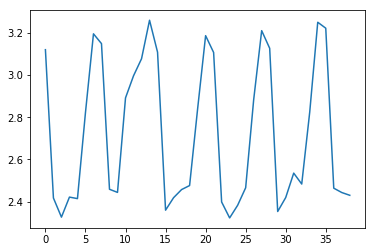

In [31]:
plt.plot(testpreds[129])

In [32]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [33]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.942374   
air_0164b9927d20bcc3_2017-04-23              1.315895   
air_0241aa3964b7f861_2017-04-23              2.357379   
air_0328696196e46f18_2017-04-23              2.098019   
air_034a3d5b40d5b1b1_2017-04-23              3.511466   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.975290  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   2.728087  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.563233  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.150012  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  32.497334

In [34]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [35]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [36]:
submission.to_csv("../submission/l4_3006_xgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')